<a href="https://colab.research.google.com/github/hopedom/DS5/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%8B%A4%EC%9D%8C%EC%97%90_%EB%B3%BC_%EC%98%81%ED%99%94_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 개요
Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템 제작


In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

2.2.2
2.19.0


In [2]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_path = '/content/drive/MyDrive/DS/9.추천시스템/data/ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    data = data.sort_values(['UserId', 'Time']).reset_index(drop=True)  # data를 id와 시간 순서로 정렬해줍니다.

    return data

data = load_data(train_path, None)

data

,UserId,ItemId,Rating,Time
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103
...,...,...,...,...
1000204,6040,2917,4,997454429
1000205,6040,1921,4,997454464
1000206,6040,1784,3,997454464
1000207,6040,161,3,997454486


여기서 이전 실습 내역과 가장 크게 다른 부분

- SessionID 대신 UserID 항목  
  이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보 포함  
  이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목  
  UnixTime 포멧. 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## 진행 순서

Step 1. 데이터의 전처리
___
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

Step 2. 미니 배치의 구성
___
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

Step 3. 모델 구성
___
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

Step 4. 모델 학습
___
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

Step 5. 모델 테스트
___
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.


# 데이터 전처리

## SessionId

- UserId 기준, 연속된 이벤트 간의 시간 차이(time_diff) 분포를 시각화
- 세션별 최대 유지시간 설정
- SessionId 생성

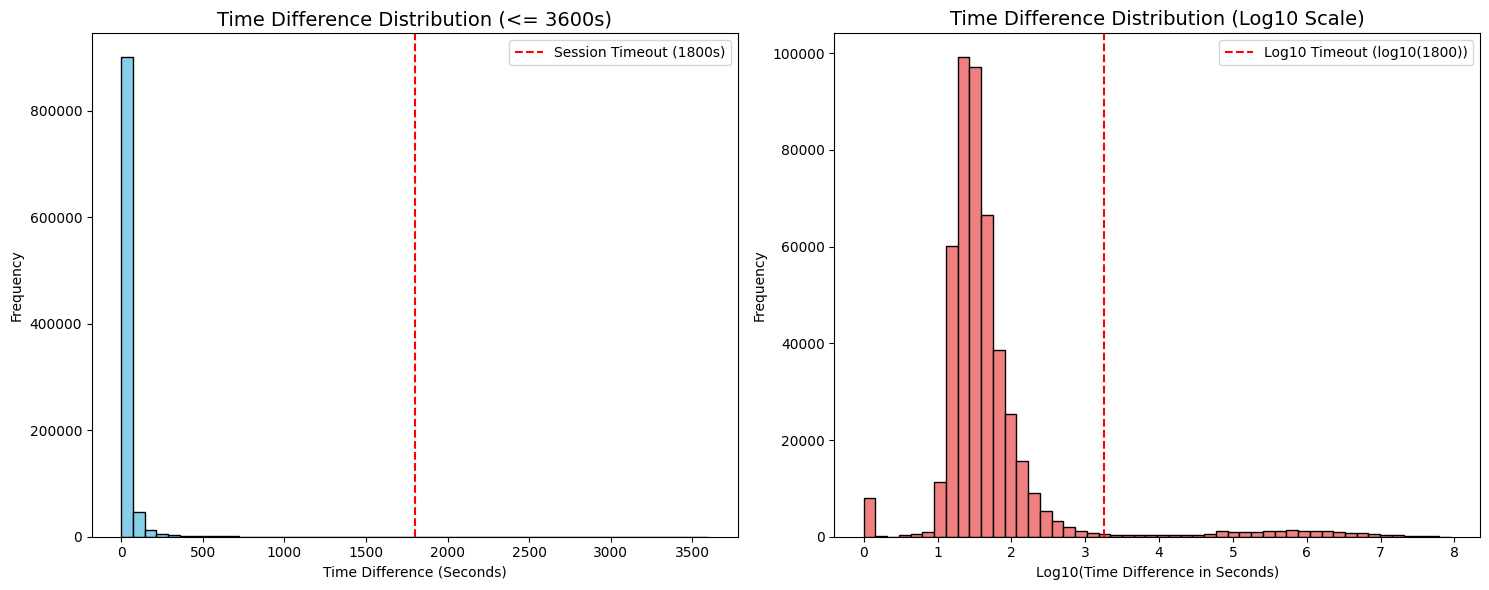

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_time_difference_distribution(df, user_id_col='UserId', time_col='Time', session_timeout=1800):
    """
    UserId 기준, 연속된 이벤트 간의 시간 차이(time_diff) 분포를 시각화합니다.

    Args:
        df (pd.DataFrame): UserId, Time 컬럼을 포함하는 데이터프레임.
        user_id_col (str): 사용자 ID 컬럼 이름.
        time_col (str): 시간(타임스탬프) 컬럼 이름.
        session_timeout (int): 세션 타임아웃 임계값 (초). 그래프에 수직선으로 표시됩니다.
    """

    # 1. 시간 차이 계산
    df = df.sort_values(by=[user_id_col, time_col])
    time_diff = df.groupby(user_id_col)[time_col].diff().dropna()

    # 초 단위로 변환 (현재 Time이 유닉스 타임스탬프이므로 바로 초 단위임)
    time_diff_seconds = time_diff

    # 2. 분포 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # --- (1) 일반 히스토그램 ---

    # 꼬리가 길어 잘 안 보이므로, 1시간(3600초) 이내의 짧은 간격만 우선 표시
    short_diffs = time_diff_seconds[time_diff_seconds <= 3600]

    axes[0].hist(short_diffs, bins=50, color='skyblue', edgecolor='black')
    axes[0].axvline(session_timeout, color='r', linestyle='--', linewidth=1.5,
                    label=f'Session Timeout ({session_timeout}s)')
    axes[0].set_title(f'Time Difference Distribution (<= 3600s)', size=14)
    axes[0].set_xlabel('Time Difference (Seconds)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # --- (2) 로그 스케일 히스토그램 ---

    # 전체 분포를 확인하기 위해 로그 스케일 적용 (빈도가 낮은 긴 간격도 확인 가능)
    # 0에 가까운 값은 제외하고 로그 변환합니다.
    log_diffs = np.log10(time_diff_seconds[time_diff_seconds > 0])

    axes[1].hist(log_diffs, bins=50, color='lightcoral', edgecolor='black')

    # 로그 스케일에서의 타임아웃 위치 (log10(1800) ≈ 3.25)
    axes[1].axvline(np.log10(session_timeout), color='r', linestyle='--', linewidth=1.5,
                    label=f'Log10 Timeout (log10({session_timeout}))')

    axes[1].set_title('Time Difference Distribution (Log10 Scale)', size=14)
    axes[1].set_xlabel('Log10(Time Difference in Seconds)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# 사용 예시 (data는 이미 로드되어 UserId, Time으로 정렬되었다고 가정)
plot_time_difference_distribution(data, session_timeout=1800) # 30분 기준

In [5]:
# 세션 Id 생성
# 30분을 세션 임계값으로 설정
SESSION_TIMEOUT = 30 * 60

def create_sessions(df):
    # UserId와 Time을 기준으로 정렬
    df = df.sort_values(by=['UserId', 'Time'])

    # 같은 UserId 내에서 이전 Time 차이 계산
    time_diff = df.groupby('UserId')['Time'].diff()

    # 시간 차이가 임계값을 초과하거나 (True), UserId가 변경되면 (NaN) 새 세션 시작
    new_session = (time_diff > SESSION_TIMEOUT) | (time_diff.isnull())

    # 누적 합(cumsum)을 통해 세션 ID 생성
    # 새 세션 시작 (True) 시 카운트를 1 증가시켜 SessionId를 부여
    df['SessionId'] = new_session.cumsum()

    return df

In [6]:
data = create_sessions(data)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,1
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,1
...,...,...,...,...,...
1000204,6040,2917,4,997454429,25162
1000205,6040,1921,4,997454464,25162
1000206,6040,1784,3,997454464,25162
1000207,6040,161,3,997454486,25162


In [7]:
data['SessionId'].nunique(), data['UserId'].nunique(), data['ItemId'].nunique()

(25163, 6040, 3706)

## session_length
- SessionId를 기준으로 세션별로 몇 번의 액션(rating 등록)을 취했는지 시각화
- 99% 분위수를 활용하여 데이터 필터링을 수행

In [8]:
session_length = data.groupby('SessionId').size()
session_length

,0
SessionId,
1,40
2,13
3,129
4,51
5,21
...,...
25159,7
25160,14
25161,1


In [9]:
session_length.median(), session_length.mean()

(6.0, np.float64(39.74919524698963))

In [10]:
session_length.min(), session_length.max()

(1, 1193)

세션의 길이 확인결과, 1부터 1193까지 넓은 범위의 값을 가지는 것으로 확인되었습니다.
이에 세션의 길이에 대한 시각화 분석 수행하였습니다.

In [11]:
session_length.value_counts().sort_index()

,count
1,6879
2,2529
3,1264
4,816
5,684
...,...
1016,1
1062,1
1088,1
1158,1


In [12]:
def plot_session_length(session_length):
  length_count = session_length.groupby(session_length).size()
  length_percent_cumsum = length_count.cumsum() / length_count.sum()

  import matplotlib.pyplot as plt
  from matplotlib.ticker import PercentFormatter

  plt.figure(figsize=(20, 6))
  plt.bar(x=length_percent_cumsum.index, height=length_percent_cumsum, color='red')

  xticks_index = length_percent_cumsum.index
  selected_xticks = xticks_index[xticks_index % 10 == 0] # 10의 배수만 선택

  plt.xticks(selected_xticks, rotation=45)
  plt.yticks(np.arange(0, 1.01, 0.05))
  plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

  plt.title('Cumsum Percentage ', size=20)
  plt.show()

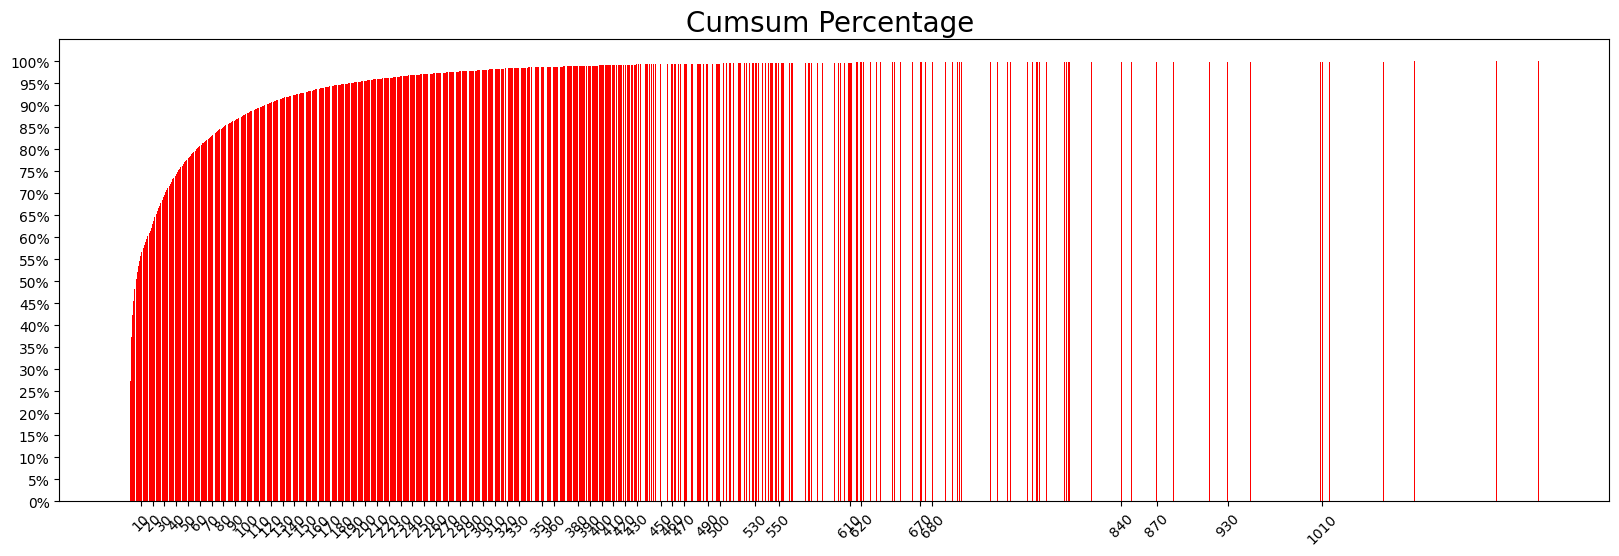

In [13]:
plot_session_length(session_length)

In [14]:
print(session_length.quantile([0.95, 0.99, 0.999]))

0.950    186.000
0.990    386.380
0.999    764.352
dtype: float64


세션 길이 분포 확인결과, 세션 길이가 비정상으로 보이는 데이터가 확인되었습니다.   
이에, 99% 분위수를 활용하여 필터링을 수행하였습니다.

In [15]:
# 99% 분위수를 초과하는 세션을 제거
MAX_SESSION_LENGTH = session_length.quantile(0.99) # 99% 분위수 값

# 제거할 SessionId 리스트 확보
long_sessions = session_length[session_length > MAX_SESSION_LENGTH].index

# 해당 SessionId를 data에서 제거
data = data[~data['SessionId'].isin(long_sessions)]

# 길이가 1인 세션도 제거
short_sessions = session_length[session_length == 1].index
data = data[~data['SessionId'].isin(short_sessions)]

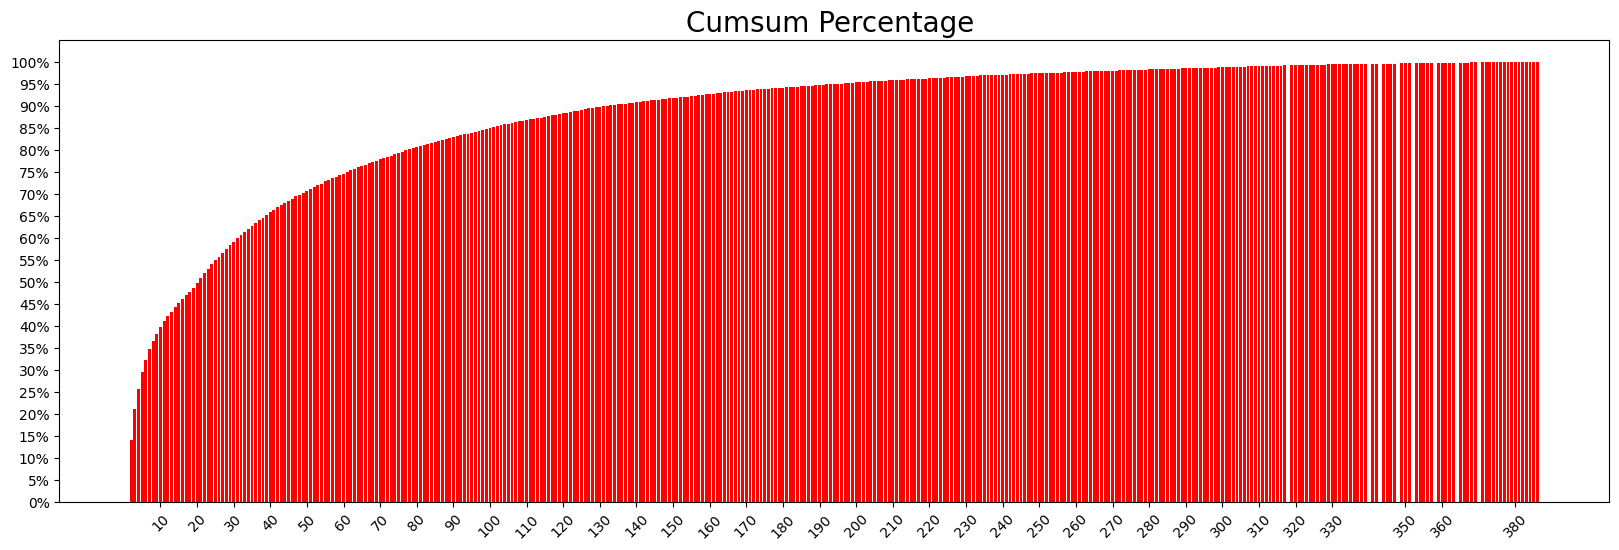

In [16]:
session_length = data.groupby('SessionId').size()

plot_session_length(session_length)

In [17]:
data['SessionId'].nunique()

18032

필터링 결과 Session 수는 `25163`에서 `18032`로 줄어들었음을 확인하였습니다.

## Time
unix time 포멧의 time 컬럼을 datetime 포멧으로 변환 수행

In [18]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [19]:
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,1
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
1000203,6040,232,5,2001-08-10 14:39:58,25162
1000204,6040,2917,4,2001-08-10 14:40:29,25162
1000205,6040,1921,4,2001-08-10 14:41:04,25162
1000206,6040,1784,3,2001-08-10 14:41:04,25162


## ItemID

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_item_frequency_cumsum(data, item_col='ItemId', max_freq_to_show=1000):
    """
    아이템 빈도수의 누적 백분율 분포를 시각화합니다.

    Args:
        data (pd.DataFrame): ItemId 컬럼을 포함하는 데이터프레임.
        item_col (str): 아이템 ID 컬럼 이름.
        max_freq_to_show (int): x축에 표시할 최대 빈도수 (빈도가 매우 높은 소수 아이템 제외).
    """

    # 아이템별 빈도수 계산 및 정렬
    item_counts = data.groupby(item_col).size()
    freq_of_freq = item_counts.groupby(item_counts).size().sort_index()

    total_items = freq_of_freq.sum()
    item_cumsum = freq_of_freq.cumsum() / total_items
    limited_cumsum = item_cumsum[item_cumsum.index <= max_freq_to_show]

    plt.figure(figsize=(15, 6))
    plt.bar(x=limited_cumsum.index, height=limited_cumsum, color='darkgreen', edgecolor='none')

    # 분석에 유용한 수직선 표시 (빈도수 1 지점)
    if 1 in limited_cumsum.index:
        plt.axvline(1, color='red', linestyle='--', linewidth=2, label='Min Count = 1')

    plt.ylim(0, 1.05)
    y_ticks = np.arange(0, 1.01, 0.05)
    plt.yticks(y_ticks)

    plt.xticks(np.unique(np.concatenate(([1], np.arange(10, limited_cumsum.index.max(), 50)))), rotation=45, ha='right')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

    plt.title(f'Item Frequency Cumulative Percentage (Up to Frequency {max_freq_to_show})', size=16)
    plt.xlabel('Item Frequency (Number of Ratings)', size=12)
    plt.ylabel('Cumulative Percentage of Items', size=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5)
    plt.tight_layout()
    plt.show()

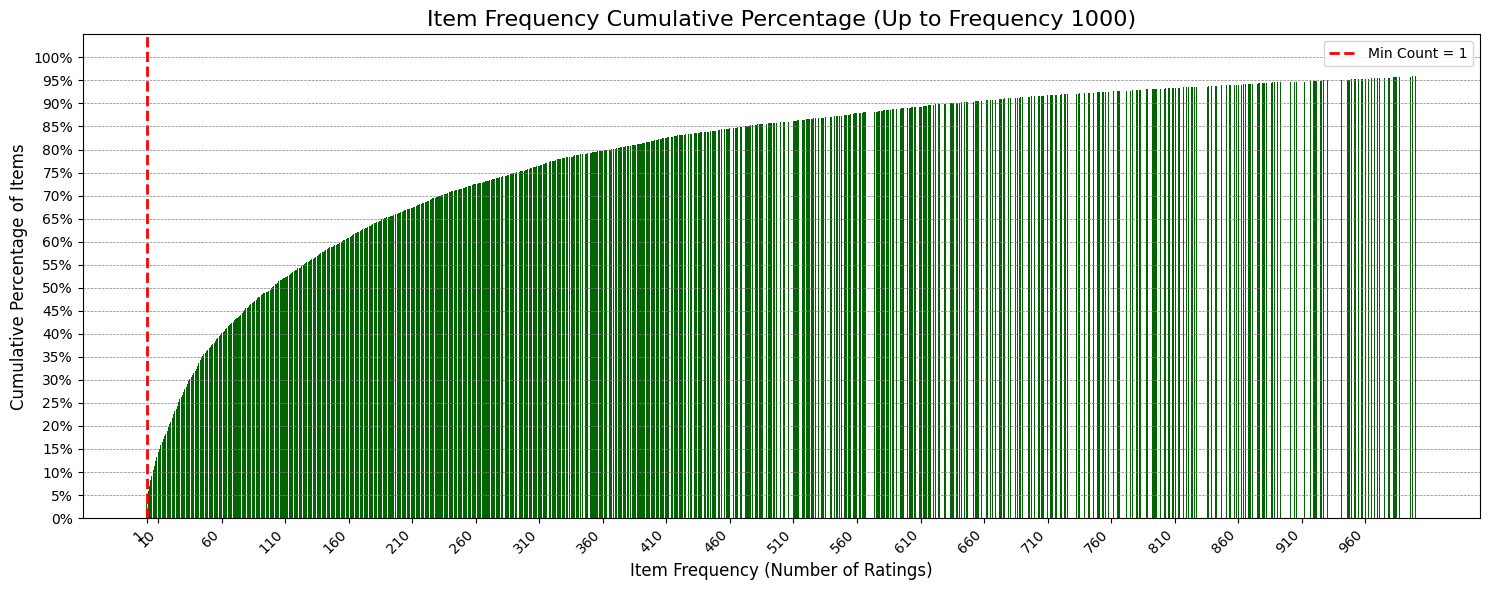

In [21]:
plot_item_frequency_cumsum(data)

In [22]:
MIN_ITEM_COUNT = 2

# 임계값 미만인 ItemId 리스트 추출
item_counts = data.groupby('ItemId').size().sort_values()
rare_items = item_counts[item_counts < MIN_ITEM_COUNT].index

# data 데이터프레임에서 해당 아이템이 포함된 행 제거
data = data[~data['ItemId'].isin(rare_items)].copy()

print(f"제거된 희소 아이템 개수: {len(rare_items)}")
print(f"제거 후 남은 데이터 행 수: {len(data)}")

제거된 희소 아이템 개수: 123
제거 후 남은 데이터 행 수: 857027


## Train / Valid / Test split
모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.


In [23]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display
import pandas as pd
import numpy as np

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()

    # Convert session_last_time values to a numpy array of datetime64 for robust comparison
    session_last_time_np = session_last_time.values.astype('datetime64[ns]')
    date_threshold = final_time - dt.timedelta(days=n_days)

    session_in_train = session_last_time[session_last_time_np < date_threshold].index
    session_in_test = session_last_time[session_last_time_np >= date_threshold].index


    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    # Ensure items in the test set are also present in the training set
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [24]:
tr, test = split_by_date(data, n_days=14)
tr, val = split_by_date(tr, n_days=14)

In [25]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 855638
	 Sessions: 17938
	 Items: 3549
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-01-31 01:28:06

* valid Set Stats Info
	 Events: 848
	 Sessions: 41
	 Items: 667
	 First Time : 2003-01-31 17:23:06
	 Last Time : 2003-02-14 02:02:32

* test Set Stats Info
	 Events: 541
	 Sessions: 53
	 Items: 464
	 First Time : 2003-02-15 00:15:09
	 Last Time : 2003-02-28 17:49:50



In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [27]:
from pathlib import Path

save_path = Path('/content/drive/MyDrive/DS/9.추천시스템/data/')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 미니 배치 구성

### SessionDataset


In [28]:
import numpy as np
import pandas as pd
from pathlib import Path

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,1,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,1,4
5,1,1836,5,2000-12-31 22:02:52,1,5
6,1,3408,4,2000-12-31 22:04:35,1,6
7,1,2804,5,2000-12-31 22:11:59,1,7
8,1,1207,4,2000-12-31 22:11:59,1,8
9,1,1193,5,2000-12-31 22:12:40,1,9


In [30]:
# click_offsets: 각 세션이 시작된 인덱스
tr_dataset.click_offsets

array([     0,     53,    182, ..., 855176, 855299, 855638], dtype=int32)

### SessionDataLoader

In [31]:
# SessionDataLoader 클래스 (기존 학습 소스)
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC. Session-parallel mini-batch generator."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size
        #self.batch_size = min(batch_size, len(dataset.session_idx))

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,): Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start (data df 기준)
        end : Index Where Session End (data df 기준)
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            # 현재 배치에 포함된 세션들 중 가장 짧은 길이 - 1
            min_len = (end - start).min() - 1

            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)      # 첫 배치에 사용할 세션의 고유 Index (0, 1, ..., batch_size-1)
        last_session = self.batch_size - 1      # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.

        # SessionDataset의 session_idx를 사용하여 data df 상의 실제 시작/끝 위치를 가져옴
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]

        mask = np.array([])  # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False        # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len    # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        # end와 start가 1칸 차이 (start == end - 1) 나는 것은 세션의 마지막 아이템까지 처리했음을 의미
        mask = np.arange(self.batch_size)[(end - start) == 1]

        # mask에 추가된 세션 개수만큼 새로운 세션을 가져와 교체합니다.
        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i

            # 모든 세션을 다 순회한 경우
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break

            # 종료된 세션 대신 새로운 세션의 시작점과 끝점을 기록합니다.
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,2000-12-31 22:00:19,1,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,1,4
5,1,1836,5,2000-12-31 22:02:52,1,5
6,1,3408,4,2000-12-31 22:04:35,1,6
7,1,2804,5,2000-12-31 22:11:59,1,7
8,1,1207,4,2000-12-31 22:11:59,1,8
9,1,1193,5,2000-12-31 22:12:40,1,9


In [33]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 모델 구성

## Evaluation Metric

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    # batch_shape=(batch, timesteps, features)로 "배치 크기 고정"
    inputs = Input(batch_shape=(args.batch_size, None, args.num_items), name="input")

    x = GRU(args.hsz, return_sequences=False, stateful=True, name="session_gru")(inputs)
    x = Dropout(args.drop_rate)(x)
    outputs = Dense(args.num_items, activation='softmax', name="pred")(x)

    model = Model(inputs, outputs)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [38]:
model = create_model(args)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 50)               │       540,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       180,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,149 (2.75 MB)

 Trainable params: 721,149 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

#모델 학습

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    actual_batch_size = min(args.batch_size, len(train_dataset.session_idx))
    train_loader = SessionDataLoader(train_dataset, batch_size=actual_batch_size)

    tf.config.run_functions_eagerly(True)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // actual_batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.
#
            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


# def reset_hidden_states(model, mask):
#     gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
#     hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
#     for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
#         hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
#     gru_layer.reset_states(states=hidden_states)

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='session_gru')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
      hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    # gru_layer.reset_states(states=hidden_states)
    # gru_layer.reset_states(hidden_states)
    gru_layer.states[0].assign(hidden_states)

# def reset_hidden_states(model, mask):
#     """
#     종료된 세션에 해당하는 GRU Hidden State를 0으로 초기화합니다.
#     """
#     # 1. GRU Layer를 가져옵니다.
#     # 모델 정의 시 name='GRU'로 설정했음을 가정합니다.
#     try:
#         gru_layer = model.get_layer(name='GRU')
#     except ValueError:
#         print("경고: 'GRU'라는 이름의 레이어를 찾을 수 없습니다. 모델 레이어 이름을 확인해 주세요.")
#         return

#     # 2. 현재 Hidden State 텐서의 Variable 객체를 가져옵니다.
#     # GRU는 상태가 1개이므로 states[0]을 사용합니다.
#     # states[0]은 (Batch Size, Hidden Size) 형태의 tf.Variable입니다.
#     hidden_state_variable = gru_layer.states[0]
#     # .numpy()를 사용하여 Variable의 현재 값을 NumPy 배열로 가져옵니다.
#     hidden_states_np = hidden_state_variable.numpy()

#     # 3. 마스크(종료된 세션)에 해당하는 상태를 0으로 초기화합니다.
#     # mask는 배치 내에서 종료된 세션의 인덱스(0, 1, 2, ...)를 담고 있습니다.
#     for elt in mask:
#         hidden_states_np[elt, :] = 0  # 해당 인덱스의 모든 차원(Hidden Size)을 0으로 설정

#     # 4. 수정된 NumPy 배열을 GRU Layer의 상태 Variable에 직접 할당합니다.
#     # (주의: K.set_value 대신 tf.Variable의 .assign() 메소드를 사용합니다.)
#     hidden_state_variable.assign(hidden_states_np)

#     # 이 과정만으로 상태가 업데이트되므로, 별도로 gru_layer.reset_states()를 호출할 필요가 없습니다.



def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    #loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    actual_batch_size = min(args.batch_size, len(dataset.session_idx))
    loader = SessionDataLoader(dataset, batch_size=actual_batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        if isinstance(model, Model): # Keras Model 객체인 경우에만 초기화
          reset_hidden_states(model, mask)

        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        # batch사이즈를 계속 맞춰줘야함
        if input_ohe.shape[0] < args.batch_size:
            pad_len = args.batch_size - input_ohe.shape[0]
            padding = np.zeros((pad_len, 1, args.num_items))
            input_ohe = np.concatenate([input_ohe, padding], axis=0)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        #pred_dict = model(input_ohe); pred = pred_dict['dense_1']

        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
train_model(model, args)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:09,  1.18it/s]


	 - Recall@20 epoch 1: 0.000000
	 - MRR@20    epoch 1: 0.000000



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:07,  1.40it/s]


	 - Recall@20 epoch 2: 0.000000
	 - MRR@20    epoch 2: 0.000000



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:10,  1.02it/s]

	 - Recall@20 epoch 3: 0.000000
	 - MRR@20    epoch 3: 0.000000



# 모델 테스트

In [41]:
# Args 객체를 현재 데이터(tr, val, test)로 초기화
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [42]:
# 최종 테스트 평가
print("\n" + "="*50)
print("최종 테스트 평가")
print("="*50 + "\n")

test_recall, test_mrr = get_metrics(args.test, model, args, args.k)

print(f"\n최종 결과:")
print(f"Test Recall@{args.k}: {test_recall:.4f}")
print(f"Test MRR@{args.k}: {test_mrr:.4f}")


최종 테스트 평가



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Evaluation:  14%|█▍        | 1/7 [00:01<00:06,  1.05s/it]


최종 결과:
Test Recall@20: 0.0789
Test MRR@20: 0.0164


| 실험 번호 | 목표 | 변화 요인 | 기본값 | 실험값 1 | 실험값 2 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **실험 1** | Hidden Size 최적화 | hsz | 50 | 100 | 200 |
| **실험 2** | Learning Rate 영향 분석 | lr | 0.001 | 0.01 | 0.0001 |
| **실험 3** | Dropout Rate를 통한 과적합 방지 | drop_rate | 0.1 | 0.3 | 0.5 |
| **실험 4 (선택)** | GRU 층 깊이 증가 | 레이어 개수 | 1개 | 2개 (Stacked GRU) | N/A |

In [43]:
BASE_ARGS = {
    'batch_size': 64,
    'hsz': 50,
    'drop_rate': 0.1,
    'lr': 0.001,
    'epochs': 3,
    'k': 20
}

# 실험 목표에 따른 변화 요인 정의
EXPERIMENTS = {
    'Experiment 1 (hsz)': {
        'target_param': 'hsz',
        'values': [100, 200]
    },
    'Experiment 2 (lr)': {
        'target_param': 'lr',
        'values': [0.01, 0.0001]
    },
    'Experiment 3 (drop_rate)': {
        'target_param': 'drop_rate',
        'values': [0.3, 0.5]
    }
}

In [47]:
def run_single_experiment(args_base, target_param, value, tr_data, val_data, test_data):
    """
    단일 하이퍼파라미터 조건으로 모델을 훈련하고 테스트하여 결과를 반환합니다.
    """
    import copy


    # 기본 인수를 복사하여 새 실험 인수를 생성합니다.
    current_args_dict = copy.deepcopy(args_base)
    current_args_dict[target_param] = value

    # Args 클래스 인스턴스 생성 (tr, val, test 데이터는 노트북에서 이미 로드되었다고 가정)
    # 현재 노트북의 변수 이름을 직접 사용합니다.
    current_args = Args(
        tr_data, val_data, test_data,
        batch_size=current_args_dict['batch_size'],
        hsz=current_args_dict['hsz'],
        drop_rate=current_args_dict['drop_rate'],
        lr=current_args_dict['lr'],
        epochs=current_args_dict['epochs'],
        k=current_args_dict['k']
    )


    print(f"\n--- Starting Experiment: {target_param}={value} ---")
    print(f"Hyperparameters: hsz={current_args.hsz}, lr={current_args.lr}, drop_rate={current_args.drop_rate}")

    # 1. 모델 생성
    model = create_model(current_args)

    # 2. 모델 훈련
    # Note: train_model 내부에 get_metrics(val) 호출이 포함되어 있음
    train_model(model, current_args)

    # 3. 최종 테스트
    test_recall, test_mrr = get_metrics(args.test, model, current_args, current_args.k)

    # 4. 결과 정리
    result = {
        'recall@20': test_recall,
        'mrr@20': test_mrr,
        'hsz': current_args.hsz,
        'lr': current_args.lr,
        'drop_rate': current_args.drop_rate,
    }
    print(f"--- Experiment Finished: Recall@20={test_recall:.4f}, MRR@20={test_mrr:.4f} ---\n")
    return result

In [48]:
def run_all_experiments():
    """정의된 모든 실험을 실행하고 결과를 EXPERIMENT_RESULTS에 저장합니다."""

    try:
        tr_data = tr
        val_data = val
        test_data = test
    except NameError:
        print("Error: 'tr', 'val', 'test' 변수가 Jupyter Notebook에 정의되지 않았습니다. 데이터를 로드한 후 실행해주세요.")
        return

    # 기본값 실험(Baseline) 추가
    print("--- Running Baseline Experiment ---")
    baseline_result = run_single_experiment(BASE_ARGS, 'hsz', BASE_ARGS['hsz'], tr_data, val_data, test_data)
    EXPERIMENT_RESULTS['Baseline'] = baseline_result

    # 나머지 정의된 실험 실행
    for exp_name, exp_details in EXPERIMENTS.items():
        target_param = exp_details['target_param']
        for value in exp_details['values']:
            # 실험 식별자 생성 (예: 'Experiment 1 (hsz=100)')
            exp_id = f"{exp_name} ({target_param}={value})"

            # 단일 실험 실행
            result = run_single_experiment(BASE_ARGS, target_param, value, tr_data, val_data, test_data)

            # 결과 저장
            EXPERIMENT_RESULTS[exp_id] = result

    # 최종 결과 출력
    print("\n=======================================================")
    print("ALL EXPERIMENTS COMPLETED. FINAL RESULTS:")
    print("=======================================================")
    for name, res in EXPERIMENT_RESULTS.items():
        print(f"[{name:30}]: Recall@20={res['recall@20']:.4f}, MRR@20={res['mrr@20']:.4f}")

    return EXPERIMENT_RESULTS

In [49]:
# 결과를 저장할 딕셔너리
EXPERIMENT_RESULTS = {}

EXPERIMENT_RESULTS = run_all_experiments()

--- Running Baseline Experiment ---

--- Starting Experiment: hsz=50 ---
Hyperparameters: hsz=50, lr=0.001, drop_rate=0.1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 50)               │       540,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       180,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,149 (2.75 MB)

 Trainable params: 721,149 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.31it/s]


	 - Recall@20 epoch 1: 0.000000
	 - MRR@20    epoch 1: 0.000000



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:09,  1.11it/s]


	 - Recall@20 epoch 2: 0.000000
	 - MRR@20    epoch 2: 0.000000



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.32it/s]


	 - Recall@20 epoch 3: 0.000000
	 - MRR@20    epoch 3: 0.000000



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:05,  1.17it/s]

--- Experiment Finished: Recall@20=0.0526, MRR@20=0.0108 ---


--- Starting Experiment: hsz=100 ---
Hyperparameters: hsz=100, lr=0.001, drop_rate=0.1


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 100)              │     1,095,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (64, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       358,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,749 (5.55 MB)

 Trainable params: 1,453,749 (5.55 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.34it/s]


	 - Recall@20 epoch 1: 0.031250
	 - MRR@20    epoch 1: 0.007812



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:07,  1.40it/s]


	 - Recall@20 epoch 2: 0.093750
	 - MRR@20    epoch 2: 0.010045



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:07,  1.43it/s]


	 - Recall@20 epoch 3: 0.093750
	 - MRR@20    epoch 3: 0.021329



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:05,  1.20it/s]

--- Experiment Finished: Recall@20=0.0526, MRR@20=0.0150 ---


--- Starting Experiment: hsz=200 ---
Hyperparameters: hsz=200, lr=0.001, drop_rate=0.1


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 200)              │     2,250,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (64, 200)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       713,349 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,963,949 (11.31 MB)

 Trainable params: 2,963,949 (11.31 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.24it/s]


	 - Recall@20 epoch 1: 0.031250
	 - MRR@20    epoch 1: 0.006250



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.26it/s]


	 - Recall@20 epoch 2: 0.031250
	 - MRR@20    epoch 2: 0.003906



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.33it/s]


	 - Recall@20 epoch 3: 0.031250
	 - MRR@20    epoch 3: 0.002841



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]

--- Experiment Finished: Recall@20=0.0789, MRR@20=0.0285 ---


--- Starting Experiment: lr=0.01 ---
Hyperparameters: hsz=50, lr=0.01, drop_rate=0.1


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 50)               │       540,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (64, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       180,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,149 (2.75 MB)

 Trainable params: 721,149 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.37it/s]


	 - Recall@20 epoch 1: 0.093750
	 - MRR@20    epoch 1: 0.011604



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:07,  1.45it/s]


	 - Recall@20 epoch 2: 0.062500
	 - MRR@20    epoch 2: 0.014881



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.35it/s]


	 - Recall@20 epoch 3: 0.062500
	 - MRR@20    epoch 3: 0.035156



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]

--- Experiment Finished: Recall@20=0.0789, MRR@20=0.0085 ---


--- Starting Experiment: lr=0.0001 ---
Hyperparameters: hsz=50, lr=0.0001, drop_rate=0.1


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 50)               │       540,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (64, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       180,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,149 (2.75 MB)

 Trainable params: 721,149 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.37it/s]


	 - Recall@20 epoch 1: 0.031250
	 - MRR@20    epoch 1: 0.002404



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.29it/s]


	 - Recall@20 epoch 2: 0.000000
	 - MRR@20    epoch 2: 0.000000



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.32it/s]


	 - Recall@20 epoch 3: 0.000000
	 - MRR@20    epoch 3: 0.000000



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]

--- Experiment Finished: Recall@20=0.0000, MRR@20=0.0000 ---


--- Starting Experiment: drop_rate=0.3 ---
Hyperparameters: hsz=50, lr=0.001, drop_rate=0.3


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 50)               │       540,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (64, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       180,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,149 (2.75 MB)

 Trainable params: 721,149 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.33it/s]


	 - Recall@20 epoch 1: 0.031250
	 - MRR@20    epoch 1: 0.002404



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.37it/s]


	 - Recall@20 epoch 2: 0.031250
	 - MRR@20    epoch 2: 0.007812



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.33it/s]


	 - Recall@20 epoch 3: 0.125000
	 - MRR@20    epoch 3: 0.009197



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:05,  1.18it/s]

--- Experiment Finished: Recall@20=0.1053, MRR@20=0.0197 ---


--- Starting Experiment: drop_rate=0.5 ---
Hyperparameters: hsz=50, lr=0.001, drop_rate=0.5


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (64, None, 3549)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ session_gru (GRU)               │ (64, 50)               │       540,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (64, 50)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 3549)             │       180,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,149 (2.75 MB)

 Trainable params: 721,149 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.35it/s]


	 - Recall@20 epoch 1: 0.031250
	 - MRR@20    epoch 1: 0.004464



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.37it/s]


	 - Recall@20 epoch 2: 0.031250
	 - MRR@20    epoch 2: 0.001645



Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluation:   8%|▊         | 1/12 [00:00<00:08,  1.36it/s]


	 - Recall@20 epoch 3: 0.000000
	 - MRR@20    epoch 3: 0.000000



Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluation:  14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]

--- Experiment Finished: Recall@20=0.0789, MRR@20=0.0101 ---


ALL EXPERIMENTS COMPLETED. FINAL RESULTS:
[Baseline                      ]: Recall@20=0.0526, MRR@20=0.0108
[Experiment 1 (hsz) (hsz=100)  ]: Recall@20=0.0526, MRR@20=0.0150
[Experiment 1 (hsz) (hsz=200)  ]: Recall@20=0.0789, MRR@20=0.0285
[Experiment 2 (lr) (lr=0.01)   ]: Recall@20=0.0789, MRR@20=0.0085
[Experiment 2 (lr) (lr=0.0001) ]: Recall@20=0.0000, MRR@20=0.0000
[Experiment 3 (drop_rate) (drop_rate=0.3)]: Recall@20=0.1053, MRR@20=0.0197
[Experiment 3 (drop_rate) (drop_rate=0.5)]: Recall@20=0.0789, MRR@20=0.0101


In [53]:
pd.DataFrame(EXPERIMENT_RESULTS).T.sort_values('mrr@20', ascending=False)

,recall@20,mrr@20,hsz,lr,drop_rate
Experiment 1 (hsz) (hsz=200),0.078947,0.028509,200.0,0.0010,0.1
Experiment 3 (drop_rate) (drop_rate=0.3),0.105263,0.019737,50.0,0.0010,0.3
Experiment 1 (hsz) (hsz=100),0.052632,0.015038,100.0,0.0010,0.1
Baseline,0.052632,0.010796,50.0,0.0010,0.1
Experiment 3 (drop_rate) (drop_rate=0.5),0.078947,0.010065,50.0,0.0010,0.5
Experiment 2 (lr) (lr=0.01),0.078947,0.008459,50.0,0.0100,0.1
Experiment 2 (lr) (lr=0.0001),0.000000,0.000000,50.0,0.0001,0.1
